In [3]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

from tqdm import tqdm

# Import environment
import gym

# Import your TD3 components
from actor import Actor
from critic import Critic
from memory import ReplayBuffer
from td3 import TD3
from utils import OUNoise


In [4]:
# Define the list of environments to evaluate
env_names = ["Pendulum-v1", "MountainCarContinuous-v0"]

# Define a base seed for reproducibility
base_seed = 42

# Initialize a dictionary to store environment details
env_details = {}

for env_name in env_names:
    env = gym.make(env_name)
    
    # Set seeds for reproducibility
    env.seed(base_seed)
    env.action_space.seed(base_seed)
    torch.manual_seed(base_seed)
    np.random.seed(base_seed)
    
    # Get environment dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    
    env_details[env_name] = {
        "env": env,
        "state_dim": state_dim,
        "action_dim": action_dim,
        "max_action": max_action
    }
    
    print(f"Environment: {env_name}")
    print(f"  State Dimension: {state_dim}")
    print(f"  Action Dimension: {action_dim}")
    print(f"  Max Action: {max_action}\n")


Environment: Pendulum-v1
  State Dimension: 3
  Action Dimension: 1
  Max Action: 2.0

Environment: MountainCarContinuous-v0
  State Dimension: 2
  Action Dimension: 1
  Max Action: 1.0



In [5]:
# Define training parameters common to all environments
training_params = {
    "discount": 0.99,
    "tau": 0.005,
    "policy_noise": 0.2,
    "noise_clip": 0.5,
    "policy_freq": 2
}

# Define training settings
max_episodes = 1000           # Total training episodes per environment
start_timesteps = 1000        # Number of initial random steps
eval_freq = 50                # How often to evaluate the policy (in episodes)
batch_size = 256              # Batch size for training
expl_noise = 0.1              # Exploration noise
save_model = True             # Whether to save the model
save_model_freq = 100         # How often to save the model (in episodes)

# Directory setup
base_results_dir = "./results"
base_models_dir = "./models"

if not os.path.exists(base_results_dir):
    os.makedirs(base_results_dir)

if save_model and not os.path.exists(base_models_dir):
    os.makedirs(base_models_dir)

# Initialize a dictionary to store agents and replay buffers
agents = {}
replay_buffers = {}

In [6]:
# Initialize TD3 agents and Replay Buffers for each environment
for env_name, details in env_details.items():
    state_dim = details["state_dim"]
    action_dim = details["action_dim"]
    max_action = details["max_action"]
    
    # Initialize TD3 agent
    agent = TD3(
        state_dim=state_dim,
        action_dim=action_dim,
        max_action=max_action,
        discount=training_params["discount"],
        tau=training_params["tau"],
        policy_noise=training_params["policy_noise"],
        noise_clip=training_params["noise_clip"],
        policy_freq=training_params["policy_freq"]
    )
    
    agents[env_name] = agent
    
    # Initialize Replay Buffer
    replay_buffer = ReplayBuffer(state_dim, action_dim, max_size=int(1e6))
    replay_buffers[env_name] = replay_buffer
    
    print(f"Initialized TD3 agent and Replay Buffer for {env_name}")

Initialized TD3 agent and Replay Buffer for Pendulum-v1
Initialized TD3 agent and Replay Buffer for MountainCarContinuous-v0


In [7]:
def eval_policy(policy, env, seed, eval_episodes=10):
    """
    Evaluates the policy over a number of episodes.

    Args:
        policy (TD3): The trained TD3 agent.
        env (gym.Env): The environment to evaluate on.
        seed (int): The seed for reproducibility.
        eval_episodes (int): Number of episodes to evaluate.

    Returns:
        list: List of episode rewards.
    """
    eval_env = copy.deepcopy(env)
    eval_env.seed(seed + 100)
    eval_env.action_space.seed(seed + 100)

    episode_rewards = []
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        episode_reward = 0
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done, _ = eval_env.step(action)
            episode_reward += reward
        episode_rewards.append(episode_reward)

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: Rewards: {episode_rewards}")
    print("---------------------------------------")
    return episode_rewards

def evaluate_trained_actor(policy, env, seed, eval_episodes=100):
    """
    Evaluates the trained actor over 100 episodes and computes mean and std of rewards.

    Args:
        policy (TD3): The trained TD3 agent.
        env (gym.Env): The environment to evaluate on.
        seed (int): The seed for reproducibility.
        eval_episodes (int): Number of episodes to evaluate.

    Returns:
        tuple: (list of episode rewards, mean reward, std reward)
    """
    eval_env = copy.deepcopy(env)
    eval_env.seed(seed + 200)
    eval_env.action_space.seed(seed + 200)

    episode_rewards = []
    for episode in range(eval_episodes):
        state, done = eval_env.reset(), False
        episode_reward = 0
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done, _ = eval_env.step(action)
            episode_reward += reward
        episode_rewards.append(episode_reward)
        if (episode + 1) % 10 == 0:
            print(f"Completed {episode + 1}/{eval_episodes} episodes.")

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    print("---------------------------------------")
    print(f"Final Evaluation over {eval_episodes} episodes: Mean Reward: {mean_reward:.3f}, Std: {std_reward:.3f}")
    print("---------------------------------------")
    return episode_rewards, mean_reward, std_reward


In [8]:
# Initialize a dictionary to store evaluation results
evaluation_results = {}

for env_name, details in env_details.items():
    print(f"\n===========================\nTraining on {env_name}\n===========================")
    
    env = details["env"]
    state_dim = details["state_dim"]
    action_dim = details["action_dim"]
    max_action = details["max_action"]
    
    agent = agents[env_name]
    replay_buffer = replay_buffers[env_name]
    
    # Define file-specific directories
    file_name = f"TD3_{env_name.replace('-', '_')}_{base_seed}"
    results_dir = os.path.join(base_results_dir, env_name.replace('-', '_'))
    models_dir = os.path.join(base_models_dir, env_name.replace('-', '_'))
    
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    if save_model and not os.path.exists(models_dir):
        os.makedirs(models_dir)
    
    # Evaluate untrained policy
    print("Evaluating untrained policy...")
    initial_evaluations = eval_policy(agent, env, base_seed, eval_episodes=10)
    evaluations = initial_evaluations.copy()
    
    state, done = env.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    total_timesteps = 0  # To track total timesteps if needed
    
    # Progress bar for episodes
    pbar = tqdm(total=max_episodes, desc=f"Training {env_name}")
    
    for episode in range(1, max_episodes + 1):
        state = env.reset()
        done = False
        episode_reward = 0
        episode_timesteps = 0
        
        while not done:
            episode_timesteps += 1
            total_timesteps += 1
            
            # Select action
            if total_timesteps < start_timesteps:
                action = env.action_space.sample()
            else:
                action = (
                    agent.select_action(np.array(state))
                    + np.random.normal(0, expl_noise * max_action, size=action_dim)
                ).clip(-max_action, max_action)
            
            # Perform action
            next_state, reward, done, _ = env.step(action)
            done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0
            
            # Store data in replay buffer
            replay_buffer.add(state, action, next_state, reward, done_bool)
            
            state = next_state
            episode_reward += reward
            
            # Train agent after collecting sufficient data
            if total_timesteps >= start_timesteps:
                agent.train(replay_buffer, batch_size)
        
        # Append the episode reward
        evaluations.append(episode_reward)
        
        # Update the progress bar
        pbar.update(1)
        
        # Evaluate the policy at specified intervals
        if episode % eval_freq == 0:
            print(f"Evaluating policy at episode {episode}...")
            eval_rewards = eval_policy(agent, env, base_seed, eval_episodes=10)
            evaluations.extend(eval_rewards)  # Append evaluation rewards to the list
            np.save(os.path.join(results_dir, file_name), evaluations)
            if save_model and (episode % save_model_freq == 0):
                agent.save(os.path.join(models_dir, file_name))
        
        # Optionally, save the model at the end of training
        if save_model and (episode == max_episodes):
            agent.save(os.path.join(models_dir, file_name))
    
    pbar.close()
    
    # Store evaluations for plotting later
    evaluation_results[env_name] = evaluations



Training on Pendulum-v1
Evaluating untrained policy...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-1336.418575484741, -1276.7226580700822, -1567.510937128597, -1480.4976475547421, -1554.2862877898644, -1696.280409092772, -1166.0728969914503, -1574.2969149519147, -1445.217401381056, -1414.0500126080813]
---------------------------------------


Training Pendulum-v1:   5%|▌         | 50/1000 [00:26<09:04,  1.74it/s]

Evaluating policy at episode 50...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-122.93309811536913, -131.92662369038754, -249.95924204393597, -117.69327223915934, -255.24280203645657, -235.52502473059718, -133.63093620580733, -241.63466333259552, -123.95001351445893, -120.32576265873391]
---------------------------------------


Training Pendulum-v1:  10%|█         | 100/1000 [00:55<08:49,  1.70it/s]

Evaluating policy at episode 100...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-115.92596888906475, -127.4130719978694, -238.17027494418838, -113.67268868335465, -243.86483529096108, -236.2733289460528, -123.60335899106589, -235.32416025111584, -123.18205424280315, -116.30809009200864]
---------------------------------------


Training Pendulum-v1:  15%|█▌        | 150/1000 [01:25<08:24,  1.68it/s]

Evaluating policy at episode 150...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-119.09440473811537, -130.02560985267039, -243.42846328746654, -116.71051412662636, -249.79344672021318, -237.8999142905252, -128.71308988814513, -237.31505062060958, -125.74062990143611, -119.42053925099819]
---------------------------------------


Training Pendulum-v1:  20%|██        | 200/1000 [01:55<07:55,  1.68it/s]

Evaluating policy at episode 200...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-116.82665031283362, -128.5990016852155, -239.75381359810072, -114.14920770482752, -246.64425105747944, -236.07011748831772, -126.20915917450579, -239.57090116479864, -123.73453564995765, -116.73927805871706]
---------------------------------------


Training Pendulum-v1:  25%|██▌       | 250/1000 [02:25<07:25,  1.68it/s]

Evaluating policy at episode 250...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-123.77516901577492, -133.220527969201, -244.28293095272923, -120.98328828148101, -252.6975155455551, -242.77209111260242, -132.1265473850032, -242.89331015241027, -130.66859975334995, -123.54435135317067]
---------------------------------------


Training Pendulum-v1:  30%|███       | 300/1000 [02:56<06:56,  1.68it/s]

Evaluating policy at episode 300...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-121.4929154971464, -131.81186341328666, -239.2315207902537, -116.83120490735932, -244.99335608894137, -238.39759342100606, -128.22032337071985, -239.6508139685587, -126.09920491516067, -119.53489603585076]
---------------------------------------


Training Pendulum-v1:  35%|███▌      | 350/1000 [03:26<06:27,  1.68it/s]

Evaluating policy at episode 350...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-122.10435135529883, -131.60309394926912, -236.4321076240024, -116.67660022159049, -241.72635869702174, -237.51492510768765, -129.12593161758522, -239.88361367216396, -126.26016805355003, -119.39363910608297]
---------------------------------------


Training Pendulum-v1:  40%|████      | 400/1000 [03:56<05:54,  1.69it/s]

Evaluating policy at episode 400...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-124.96299293390959, -135.0184679572373, -239.76934782124417, -120.67987359392406, -245.6910122092805, -242.98311139618704, -132.65865451693472, -240.8372893586649, -130.71476294156943, -123.37248978648898]
---------------------------------------


Training Pendulum-v1:  45%|████▌     | 450/1000 [04:26<05:27,  1.68it/s]

Evaluating policy at episode 450...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-121.92191530939158, -133.17471304176777, -236.51840942459313, -118.94301137468447, -242.5868300886319, -241.30838836882836, -131.46020200679607, -242.98537760009768, -129.59101865771314, -121.58813398852429]
---------------------------------------


Training Pendulum-v1:  50%|█████     | 500/1000 [04:57<04:54,  1.69it/s]

Evaluating policy at episode 500...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-123.89180611587122, -133.18426195802326, -236.15232684614065, -118.79555731728756, -243.96010934342792, -242.28820013174686, -132.17370609063707, -241.98595629895993, -130.26504930428055, -123.27434439785627]
---------------------------------------


Training Pendulum-v1:  55%|█████▌    | 550/1000 [05:27<04:29,  1.67it/s]

Evaluating policy at episode 550...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-123.61205428094024, -132.9975103364423, -235.52865656144817, -118.67476791107315, -240.16619142097593, -241.6587419231236, -131.3591592299213, -234.77491249151967, -128.61834683775822, -121.40484111896967]
---------------------------------------


Training Pendulum-v1:  60%|██████    | 600/1000 [05:57<03:57,  1.68it/s]

Evaluating policy at episode 600...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-123.86342461314327, -133.82415338845277, -237.14708271682795, -118.91708814053692, -240.74322384620254, -241.430075542266, -130.9414171544, -239.68751517390706, -130.29037041984174, -121.9247365995801]
---------------------------------------


Training Pendulum-v1:  65%|██████▌   | 650/1000 [06:27<03:28,  1.68it/s]

Evaluating policy at episode 650...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-122.58722476959645, -132.65245912057816, -233.26143763604006, -117.88827942700311, -240.53026419369527, -240.50421982122901, -128.34865261022068, -241.60401718483976, -129.43281264586258, -121.2754586638516]
---------------------------------------


Training Pendulum-v1:  70%|███████   | 700/1000 [06:58<02:59,  1.67it/s]

Evaluating policy at episode 700...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-128.90830483326647, -131.6773550412365, -240.6210011143529, -119.1159125170643, -245.447864481114, -241.86829419279078, -133.40414051494406, -233.10387498006935, -130.14563117196747, -121.81810214088993]
---------------------------------------


Training Pendulum-v1:  75%|███████▌  | 750/1000 [07:28<02:28,  1.69it/s]

Evaluating policy at episode 750...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-127.63783380915957, -131.9990513260221, -237.95875181480744, -118.14815491220831, -244.96482167227992, -240.96723905293618, -132.51965085337292, -234.38738401188843, -129.7976114156902, -121.1045356594387]
---------------------------------------


Training Pendulum-v1:  80%|████████  | 800/1000 [07:58<01:58,  1.69it/s]

Evaluating policy at episode 800...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-122.54206428695282, -131.84081281802366, -233.52801029193984, -118.30409814624542, -238.64414679888674, -241.52703831418376, -129.1681739012079, -234.95611233476333, -130.0600411882629, -121.19326965627188]
---------------------------------------


Training Pendulum-v1:  85%|████████▌ | 850/1000 [08:28<01:28,  1.69it/s]

Evaluating policy at episode 850...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-121.26117672229935, -132.4320081243563, -231.62597886620404, -118.53671450579962, -240.31522325473674, -240.84201861728005, -128.65248106300427, -237.6747727949229, -129.90347684002123, -121.40900669287217]
---------------------------------------


Training Pendulum-v1:  90%|█████████ | 900/1000 [08:58<00:59,  1.67it/s]

Evaluating policy at episode 900...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-121.49770775793701, -131.889371404526, -233.4649292187135, -118.57252124158458, -240.512573675277, -241.1612554117938, -128.4507364928761, -234.67320911108413, -130.34210275714864, -121.49277520898163]
---------------------------------------


Training Pendulum-v1:  95%|█████████▌| 950/1000 [09:28<00:29,  1.69it/s]

Evaluating policy at episode 950...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-121.2135596691798, -131.4964014205456, -233.95026855891982, -118.53794514527497, -242.0970171273656, -240.51939367069798, -128.47035235850277, -236.73051874816974, -130.1308825097547, -121.3746087559708]
---------------------------------------


Training Pendulum-v1: 100%|██████████| 1000/1000 [09:58<00:00,  1.68it/s]

Evaluating policy at episode 1000...


Training Pendulum-v1: 100%|██████████| 1000/1000 [09:59<00:00,  1.67it/s]

---------------------------------------
Evaluation over 10 episodes: Rewards: [-121.23740788606824, -130.92938884918703, -230.4525479920521, -118.63137688806408, -240.12580031192908, -238.68935661013347, -128.55324314862176, -236.1205309063216, -129.06611313246452, -121.98777635874873]
---------------------------------------

Training on MountainCarContinuous-v0
Evaluating untrained policy...


---------------------------------------
Evaluation over 10 episodes: Rewards: [-0.15520196882019785, -0.15396903514479032, -0.15494126512398262, -0.15568257375023634, -0.1550475739295007, -0.15430121411876846, -0.15504856766673655, -0.15507527572650862, -0.15504004175907035, -0.15573916655352907]
---------------------------------------


Training MountainCarContinuous-v0:   5%|▌         | 50/1000 [02:25<47:02,  2.97s/it]

Evaluating policy at episode 50...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-0.0019290457418237102, -8.133031011680833e-05, -0.005000880662700466, -0.0050627672821475294, -0.004818938764298574, -0.0009789543500868646, -0.004989949530601127, -0.004811325736903256, -0.004825517497447424, -0.005510801188701852]
---------------------------------------


Training MountainCarContinuous-v0:  10%|█         | 100/1000 [04:54<43:10,  2.88s/it]

Evaluating policy at episode 100...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-0.003921448497221225, -0.000641198570573368, -0.01290623216526282, -0.013285426453664569, -0.029057475390052618, -0.002193341870238911, -0.02397882383118035, -0.0300424732772875, -0.028670542996884714, -0.015764939664316253]
---------------------------------------


Training MountainCarContinuous-v0:  15%|█▌        | 150/1000 [07:24<42:06,  2.97s/it]

Evaluating policy at episode 150...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-0.013497452192485996, -0.0006206468726608076, -0.016677418806518757, -0.01638951185298901, -0.013100791703358913, -0.007056217560802524, -0.0116963403898707, -0.013723989019962309, -0.012897684747649364, -0.015211657992850467]
---------------------------------------


Training MountainCarContinuous-v0:  20%|██        | 200/1000 [09:55<39:40,  2.98s/it]

Evaluating policy at episode 200...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-0.0074414693626969515, -0.0015655572374518477, -0.02190728747388989, -0.023945820842319727, -0.03111478611971303, -0.004105887911147248, -0.03558610246849758, -0.029903980994563144, -0.03158201244379482, -0.028741300244777175]
---------------------------------------


Training MountainCarContinuous-v0:  25%|██▌       | 250/1000 [12:24<36:24,  2.91s/it]

Evaluating policy at episode 250...
---------------------------------------
Evaluation over 10 episodes: Rewards: [-0.012661791471795145, -0.010466816109521784, -0.007348089666682314, -0.007459339246231138, -0.009154548905662616, -0.012707479779270213, -0.007001484254133549, -0.009884659401927235, -0.008895937174744947, -0.006489812948804343]
---------------------------------------


Training MountainCarContinuous-v0:  29%|██▉       | 294/1000 [14:37<34:54,  2.97s/it]

KeyboardInterrupt: 

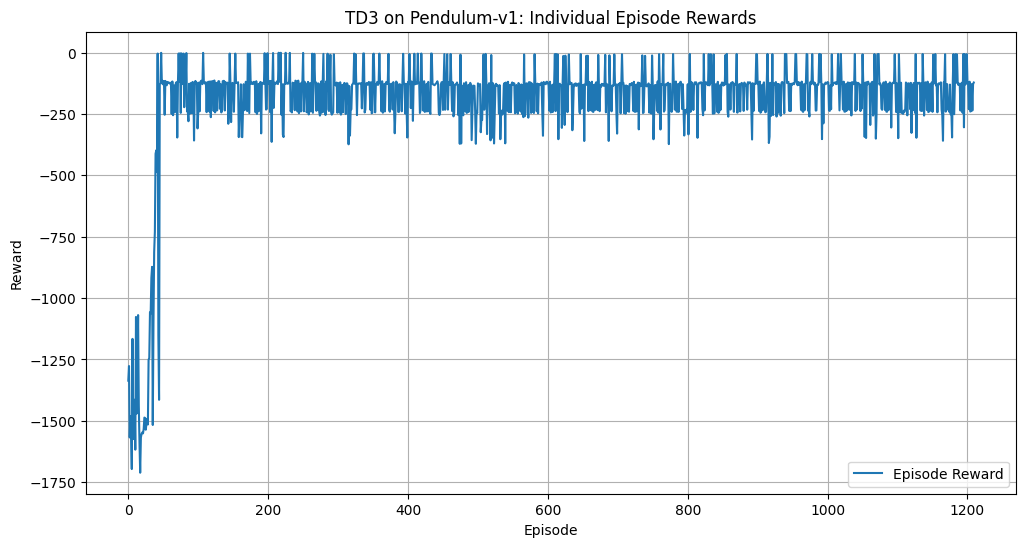

In [9]:
# Plotting individual episode rewards for each environment
for env_name, rewards in evaluation_results.items():
    plt.figure(figsize=(12,6))
    plt.plot(rewards, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'TD3 on {env_name}: Individual Episode Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

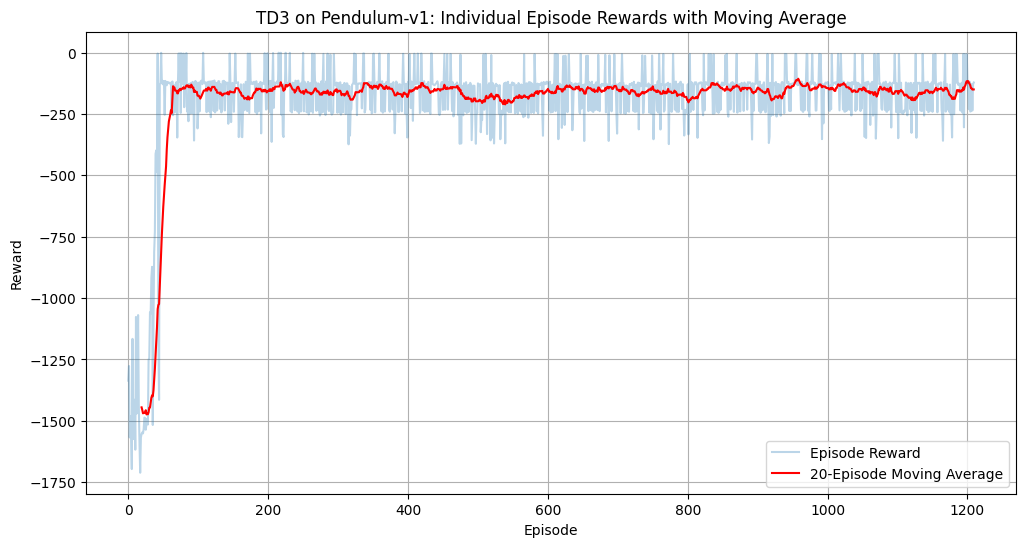

In [10]:
# Moving average for smoother visualization
window = 20

for env_name, rewards in evaluation_results.items():
    plt.figure(figsize=(12,6))
    plt.plot(rewards, label='Episode Reward', alpha=0.3)
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(rewards)), moving_avg, label=f'{window}-Episode Moving Average', color='red')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'TD3 on {env_name}: Individual Episode Rewards with Moving Average')
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
# Initialize a dictionary to store final evaluation results
final_evaluation_results = {}

for env_name, details in env_details.items():
    print(f"\n===========================\nFinal Evaluation on {env_name}\n===========================")
    
    env = details["env"]
    agent = agents[env_name]
    
    # Define file-specific directories
    file_name = f"TD3_{env_name.replace('-', '_')}_{base_seed}"
    results_dir = os.path.join(base_results_dir, env_name.replace('-', '_'))
    models_dir = os.path.join(base_models_dir, env_name.replace('-', '_'))
    
    # Load the trained actor (if not already in memory)
    # Uncomment the following line if running evaluations in a separate session
    # agent.load(os.path.join(models_dir, file_name))
    
    # Evaluate the trained actor
    final_episode_rewards, final_mean_reward, final_std_reward = evaluate_trained_actor(agent, env, base_seed, eval_episodes=100)
    
    # Store the results
    final_evaluation_results[env_name] = {
        "rewards": final_episode_rewards,
        "mean_reward": final_mean_reward,
        "std_reward": final_std_reward
    }



Final Evaluation on Pendulum-v1
Completed 10/100 episodes.
Completed 20/100 episodes.
Completed 30/100 episodes.
Completed 40/100 episodes.
Completed 50/100 episodes.
Completed 60/100 episodes.
Completed 70/100 episodes.
Completed 80/100 episodes.
Completed 90/100 episodes.
Completed 100/100 episodes.
---------------------------------------
Final Evaluation over 100 episodes: Mean Reward: -154.766, Std: 83.228
---------------------------------------

Final Evaluation on MountainCarContinuous-v0
Completed 10/100 episodes.
Completed 20/100 episodes.
Completed 30/100 episodes.
Completed 40/100 episodes.
Completed 50/100 episodes.
Completed 60/100 episodes.
Completed 70/100 episodes.
Completed 80/100 episodes.
Completed 90/100 episodes.
Completed 100/100 episodes.
---------------------------------------
Final Evaluation over 100 episodes: Mean Reward: -0.009, Std: 0.002
---------------------------------------
